In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

# Public LB 3.26102
# TRAINING
Dataset Info.

train.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사
    Book-Rating : 유저가 도서에 부여한 평점 (0점 ~ 10점)


test.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사


sample_submission.csv [제출양식]

    ID : 샘플 고유 ID
    Book-Rating : 예측한 유저가 도서에 부여할 평점

In [1]:
import pandas as pd

In [2]:
# tensorflow device 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-05-09 18:42:24.650577: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 18:42:25.079091: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 18:42:25.080483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 18:42:26.225924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-09 18:42:28.134693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-09 18:42:28.487927: W tensorflow/core/common_r

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16942478919921160875
 xla_global_id: -1]

In [3]:
import numpy as np
import random
import os
import gc

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(113) # Seed 고정

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv( 'test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [ ]:
# https://github.com/Tuckerpham/Predictive-model-for-Goodreads-Book-ratings/blob/master/Tucker%20-%20Predictive%20model%20for%20Goodreads%20Book%20Ratings%20.ipynb

In [6]:
import re 
def preprocessing_data(df):
    # preprocessing_Location
    df['Location'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Location']]
    
    df['City'] = [(i.split(',')[0]).lstrip().lower() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().lower() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().lower() for i in df['Location']]
    
    df = df.replace('na', np.nan) 
    df = df.replace('', np.nan) 
    
    new_country = df[~(df['Country'].isna())|(df['State'].isna())].groupby(['State'])['Country'].agg(pd.Series.mode).reset_index()
    new_country = new_country.rename(columns = {'Country' : 'N_Country'}) 
    
    new_state = df[~(df['State'].isna())|(df['City'].isna())].groupby(['City'])['State'].agg(pd.Series.mode).reset_index()
    new_state = new_state.rename(columns = {'State' : 'N_State'}) 
    
    new_city = df[~(df['City'].isna())|(df['Country'].isna())|(df['State'].isna())].groupby(['State', 'Country'])['City'].agg(pd.Series.mode).reset_index()
    new_city = new_city.rename(columns = {'City' : 'N_City'}) 
    
    df = pd.merge(df, new_country, on = 'State', how = 'left')
    df = pd.merge(df, new_state, on = 'City', how = 'left')
    df = pd.merge(df, new_city, on = ['State','Country'], how = 'left')
    
    df['Country'] = np.where((df['Country'] == '')|(df['Country'].astype(str) == 'nan'), df['N_Country'], df['Country'])
    df['State'] = np.where((df['State'] == '')|(df['State'].astype(str) == 'nan'), df['N_State'], df['State'])
    df['City'] = np.where((df['City'] == '')|(df['City'].astype(str) == 'nan'), df['N_City'], df['City'])
    
    df[['Country', 'State', 'City']] = df[['Country', 'State', 'City']].fillna(value= 'Unknown')
    df = df.drop(columns = ['N_Country', 'N_State', 'N_City'])

    # preprocessing
    # NaN, N/A, etc.. Change 'unknown'
    # Only using Train Data	#
    #df['City'] = np.where((df['City'] == '')|(df['City'].astype(str) == 'nan')|(df['City'].astype(str) == 'N/A'), 'UnKnown', df['City'])
    #df['State'] = np.where((df['State'] == '')|(df['State'].astype(str) == 'nan')|(df['State'].astype(str) == 'N/A'), 'UnKnown', df['State'])
    #df['Country'] = np.where((df['Country'] == '')|(df['Country'].astype(str) == 'nan')|(df['Country'].astype(str) == 'N/A')
    #                                              |(df['Country'].astype(str) == 'N/A - On The Road')|(df['Country'].astype(str) == 'X')
    #                                              |(df['Country'].astype(str) == 'Far Away...')|(df['Country'].astype(str) == 'C')
    #                                              |(df['Country'].astype(str) == 'We`Re Global!')|(df['Country'].astype(str) == 'Travelling....')
    #                                              #영원한 중국!
    #                                              |(df['Country'].astype(str) == 'La Chine Éternelle !')
    #                         ,'UnKnown', df['Country'])
	#
    ## train에 있는 정보로 County 바꾸기
    #df.loc[df['State'] == 'Michigan Usa', 'Country'] = 'Usa'
    #df.loc[df['State'] == 'Wicklow', 'Country'] = 'Ireland'
    #df.loc[df['State'] == 'Ilfov', 'Country'] = ''
    #df.loc[df['State'] == 'Liege', 'Country'] = 'Belgium'
    #df.loc[df['State'] == 'Estremadura', 'Country'] = 'Portugal'
    #df.loc[df['State'] == 'Aberdeenshire', 'Country'] = 'United Kingdom'
    #df.loc[df['State'] == 'Wi', 'Country'] = 'Wisconsin'
    #
    ## 미국 Country name 통일
    #df.loc[df['Country'] == 'America', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'United State', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'United States', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'U.S.A.', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'New York', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'U.S. Of A.', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'United Staes', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'U.S>', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'Usa Now', 'Country'] = 'Usa'
    #
    ## 영국 Country name 통일
    #df.loc[df['Country'] == 'England', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'Scotland', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'Wales', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'Ireland', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'U.K.', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'Usa (Currently Living In England)', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'Uk', 'Country'] = 'United Kingdom'
    #
    ## 스페인 Country name 통일
    #df.loc[df['Country'] == 'España ', 'Country'] = 'Spain'
    
    return df
    

In [12]:
!pip install catboost

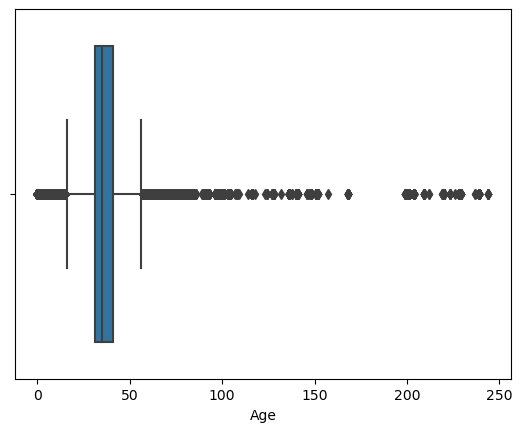

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='Age', data=train)
plt.show()

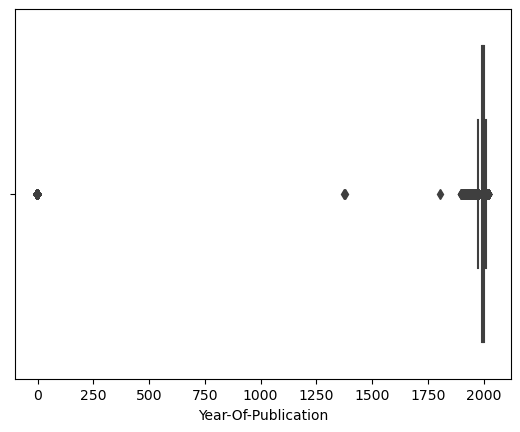

In [8]:
sns.boxplot(x='Year-Of-Publication', data=train)
plt.show()

In [9]:
#from lingua import Language, LanguageDetectorBuilder
from tqdm import tqdm

def feature_engineering(df):
    # Book-Title로 도서 언어분류 (과적합 남)
    #df['prep_title'] = df['Book-Title'].apply(preprocessing_sentence)
    #detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().with_low_accuracy_mode().build()
    #
    #all = []
    #for row in tqdm(df['prep_title'].unique()):
    #    try:
    #        language = detector.detect_language_of(row)
    #    except:
    #        language = "error"
    #        print("This row throws and error:", row)
    #    all.append(language)
    #prep_title = pd.DataFrame(df['prep_title'].unique(), columns = ['prep_title'])
    #all = [i.name if str(i) != 'None' else 'None' for i in all]
    #Language = pd.DataFrame(all, columns = ['Language'])
    #prep_title = pd.concat([prep_title, Language], axis = 1)
    #df = pd.merge(df, prep_title, on = 'prep_title', how = 'inner')
    #
    #df = df.drop(columns = ['prep_title'])
    
    # Age 그룹화    
    #labels = ['0-3','3-6','6-8','8-12','12-18','18-54','55-64','65+']
    #bins = [0, 3, 6, 8, 12, 18, 54, 64, 250]
    labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
    bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
    
    # Age 이상치 처리
    df.loc[(df['Age'] > 90) | (df['Age'] < 3), 'Age'] = np.nan
    
    # 평균값으로 대체
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Age'] = df['Age'].astype(np.int32)

    
    df['Age_gb'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
    
    # 출판년도 그룹화
    #labels = ['Unknown', '-1900', '1900-1970', '1970-2000', '2000-2010', '2010-2020', '2020-']
    #bins = [-1, 0, 1900, 1970, 2000, 2010, 2020, 3000]
    
    # 만약 출판연도가 null이 있다면 정보없음(-1)로 채움
    df['Year-Of-Publication'] = df['Year-Of-Publication'].fillna(-1)
    labels = ['Unknown', '-1900', '1900-1950', '1950-1960', '1960-1970', '1970-1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020', '2020-']
    bins = [-1, 0, 1900, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 3000]
    df['Pub_gb'] = pd.cut(df['Year-Of-Publication'], bins, labels = labels,include_lowest = True)
    
    #count변수 추가
    #df['User_count'] = df.groupby('User-ID')['User-ID'].transform('count')
    #df['Rating_count'] = df.groupby('Book-Title')['Book-Title'].transform('count')
    #df['Author_count'] = df.groupby('Book-Author')['Book-Author'].transform('count')
    return df

In [10]:
from sklearn.preprocessing import OrdinalEncoder

FEATURE = ['User-ID','Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb', 'Pub_gb']#', 'Language'] ', 

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

train_lb = feature_engineering(train_lb)
test_lb = feature_engineering(test_lb)

train_lb = preprocessing_data(train_lb)
test_lb = preprocessing_data(test_lb)

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))

In [11]:
train_lb.to_csv('train_lb.csv')
test_lb.to_csv('test_lb.csv')

In [12]:
import pandas as pd

train_lb = pd.read_csv('train_lb.csv')
test_lb = pd.read_csv('test_lb.csv')

In [13]:
X_train = train_lb.drop(columns = ['Unnamed: 0', 'ID', 'Book-Rating'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['Unnamed: 0', 'ID'])

In [ ]:
list(set(X_train.columns) - set(FEATURE))

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()    # create an object of class

scaler_FEATURE = list(set(X_train.columns) - set(FEATURE))
scaler.fit(X_train[scaler_FEATURE])       #  fit on training i/p data

X_train[scaler_FEATURE] = scaler.transform(X_train[scaler_FEATURE])    # transform model on both traing and testing data
x_test[scaler_FEATURE] = scaler.transform(x_test[scaler_FEATURE])

<Figure size 500x500 with 0 Axes>

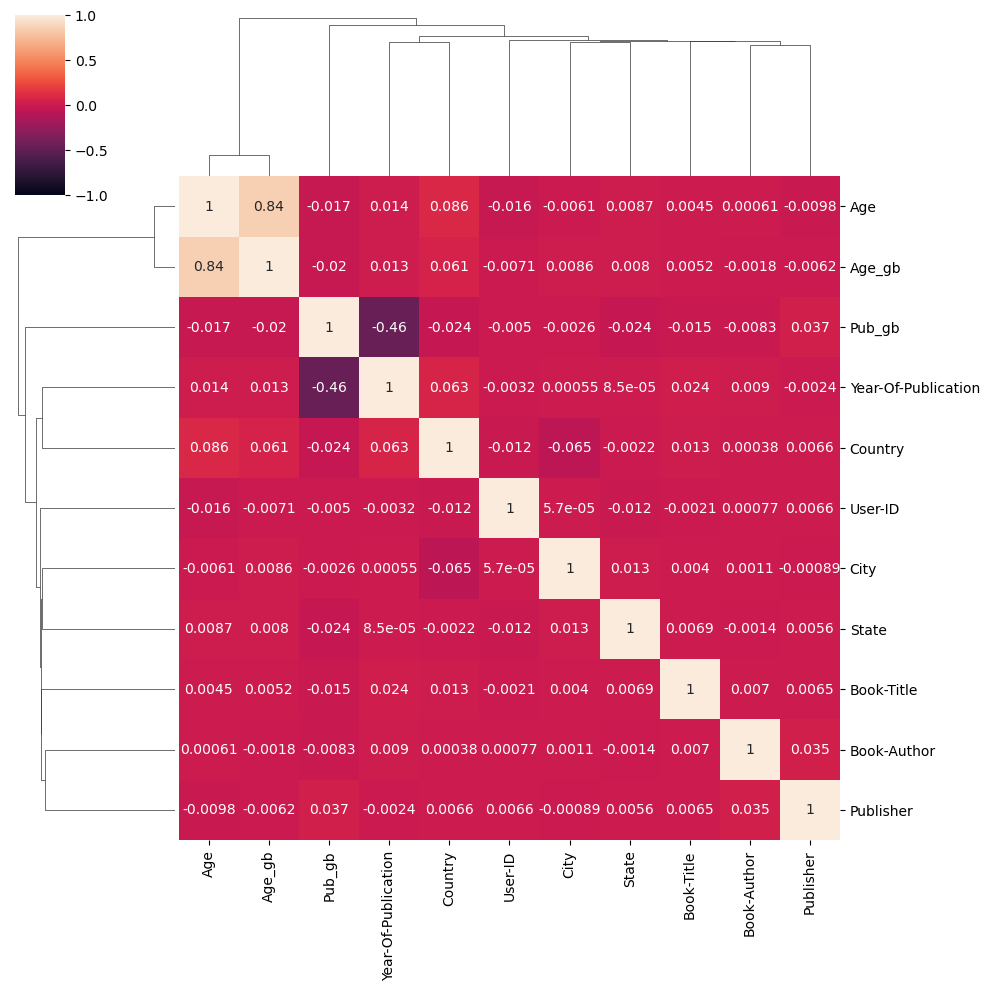

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (5, 5))
clustermap = sns.clustermap(X_train.corr(), vmin = -1, vmax = 1, annot = True)

In [78]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool

FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb', 'Pub_gb']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# random sampler
sampler = TPESampler(seed=113)

X_train[FEATURE] = X_train[FEATURE].astype('int')
X_val[FEATURE] = X_val[FEATURE].astype('int')

# define function
def objective(trial):


    cbrm_param = {
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg",1e-5, 1e-1),
        'max_bin': trial.suggest_int("max_bin", 200, 400),
        'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.01),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'iterations':trial.suggest_int("iterations", 1000, 10000),
        #'random_strength' :trial.suggest_int('random_strength', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        #'min_child_samples': trial.suggest_int("min_child_samples", 5, 100),
        'eval_metric' : 'RMSE',
        'task_type': 'GPU',
        'random_state': 113,
        'use_best_model': True,
        'bootstrap_type' : 'Poisson',
        'early_stopping_rounds' : 100
    }

    train_pool = Pool(data=X_train, label=y_train, cat_features=FEATURE)
    valid_pool = Pool(data=X_val, label=y_val, cat_features=FEATURE)

    # Generate model
    model_cbrm = CatBoostRegressor(**cbrm_param)
    model_cbrm = model_cbrm.fit(train_pool, eval_set=valid_pool, 
                           verbose=0, early_stopping_rounds=100)
                           
    MSE = mean_squared_error(y_val, np.clip(model_cbrm.predict(X_val),0,10))
    RMSE = np.sqrt(MSE)
    return RMSE
optuna_cbrm = optuna.create_study(direction='minimize', sampler=sampler)
optuna_cbrm.optimize(objective, n_trials=1000, timeout = 3600)

[I 2023-05-09 16:51:26,862] A new study created in memory with name: no-name-19bc77a1-b5d8-4097-ae79-16514c0f821b
[W 2023-05-09 16:51:29,652] Trial 0 failed with parameters: {'l2_leaf_reg': 0.08520002941808152, 'max_bin': 214, 'learning_rate': 0.009054385864287612, 'max_depth': 11, 'min_data_in_leaf': 206, 'iterations': 7306, 'subsample': 0.8678165576938894} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/chunbae/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25313/95617791.py", line 43, in objective
    model_cbrm = model_cbrm.fit(train_pool, eval_set=valid_pool,
  File "/home/chunbae/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/catboost/core.py", line 5734, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  Fil

KeyboardInterrupt: 

In [15]:
from catboost import CatBoostRegressor 

model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  0
0:	learn: 3.8400057	test: 3.8395669	best: 3.8395669 (0)	total: 90.1ms	remaining: 13m 3s
500:	learn: 3.3161097	test: 3.2883487	best: 3.2883487 (500)	total: 59.3s	remaining: 16m 9s
1000:	learn: 3.2730901	test: 3.2686848	best: 3.2686848 (1000)	total: 1m 59s	remaining: 15m 18s
1500:	learn: 3.2428905	test: 3.2611171	best: 3.2611171 (1500)	total: 3m	remaining: 14m 22s
2000:	learn: 3.2176586	test: 3.2569658	best: 3.2569658 (2000)	total: 4m 3s	remaining: 13m 35s
2500:	learn: 3.1942339	test: 3.2540494	best: 3.2540494 (2500)	total: 5m 3s	remaining: 12m 32s
3000:	learn: 3.1721057	test: 3.2519492	best: 3.2519370 (2998)	total: 6m 3s	remaining: 11m 30s
3500:	learn: 3.1506706	test: 3.2505352	best: 3.2505210 (3488)	total: 7m 8s	remaining: 10m 34s
4000:	learn: 3.1292276	test: 3.2493023	best: 3.2493019 (3999)	total: 8m 12s	remaining: 9m 37s
4500:	learn: 3.1085183	test: 3.2485191	best: 3.2484865 (4487)	total: 9m 12s	remaining: 8m 34s
5000:	learn: 3.0885895	test: 3.2480059	best: 3.2479837 (4930)	

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  1
0:	learn: 3.8399871	test: 3.8396192	best: 3.8396192 (0)	total: 87.4ms	remaining: 12m 39s
500:	learn: 3.3167016	test: 3.2781565	best: 3.2781565 (500)	total: 54.3s	remaining: 14m 48s
1000:	learn: 3.2735268	test: 3.2583848	best: 3.2583848 (1000)	total: 1m 44s	remaining: 13m 23s
1500:	learn: 3.2430348	test: 3.2507614	best: 3.2507614 (1500)	total: 2m 35s	remaining: 12m 23s
2000:	learn: 3.2166973	test: 3.2458211	best: 3.2458211 (2000)	total: 3m 25s	remaining: 11m 26s
2500:	learn: 3.1921245	test: 3.2430776	best: 3.2430776 (2500)	total: 4m 16s	remaining: 10m 36s
3000:	learn: 3.1690181	test: 3.2408444	best: 3.2408444 (3000)	total: 5m 7s	remaining: 9m 43s
3500:	learn: 3.1470691	test: 3.2391932	best: 3.2391932 (3500)	total: 5m 59s	remaining: 8m 53s
4000:	learn: 3.1255783	test: 3.2378771	best: 3.2378744 (3998)	total: 6m 51s	remaining: 8m 2s
4500:	learn: 3.1049186	test: 3.2370486	best: 3.2370444 (4496)	total: 7m 41s	remaining: 7m 10s
5000:	learn: 3.0843989	test: 3.2362060	best: 3.2362060 (

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  2
0:	learn: 3.8399857	test: 3.8394130	best: 3.8394130 (0)	total: 87ms	remaining: 12m 36s
500:	learn: 3.3182887	test: 3.2693041	best: 3.2693041 (500)	total: 47.9s	remaining: 13m 4s
1000:	learn: 3.2748831	test: 3.2483949	best: 3.2483949 (1000)	total: 1m 37s	remaining: 12m 29s
1500:	learn: 3.2433451	test: 3.2400839	best: 3.2400836 (1497)	total: 2m 26s	remaining: 11m 44s
2000:	learn: 3.2160153	test: 3.2357790	best: 3.2357732 (1999)	total: 3m 18s	remaining: 11m 3s
2500:	learn: 3.1908067	test: 3.2329387	best: 3.2329373 (2496)	total: 4m 9s	remaining: 10m 18s
3000:	learn: 3.1676006	test: 3.2307044	best: 3.2307044 (3000)	total: 5m 1s	remaining: 9m 32s
3500:	learn: 3.1457778	test: 3.2295049	best: 3.2294948 (3497)	total: 5m 54s	remaining: 8m 45s
4000:	learn: 3.1246076	test: 3.2284877	best: 3.2284841 (3994)	total: 6m 46s	remaining: 7m 56s
4500:	learn: 3.1041677	test: 3.2277741	best: 3.2277381 (4476)	total: 7m 37s	remaining: 7m 6s
5000:	learn: 3.0840753	test: 3.2270016	best: 3.2270016 (5000)

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  3
0:	learn: 3.8400054	test: 3.8395006	best: 3.8395006 (0)	total: 73.8ms	remaining: 10m 41s
500:	learn: 3.3156445	test: 3.2747719	best: 3.2747719 (500)	total: 49.3s	remaining: 13m 26s
1000:	learn: 3.2732261	test: 3.2568841	best: 3.2568841 (1000)	total: 1m 38s	remaining: 12m 36s
1500:	learn: 3.2425533	test: 3.2499699	best: 3.2499699 (1500)	total: 2m 27s	remaining: 11m 47s
2000:	learn: 3.2158735	test: 3.2459071	best: 3.2459071 (2000)	total: 3m 18s	remaining: 11m 2s
2500:	learn: 3.1915455	test: 3.2436724	best: 3.2436724 (2500)	total: 4m 10s	remaining: 10m 21s
3000:	learn: 3.1679752	test: 3.2417911	best: 3.2417911 (3000)	total: 5m 3s	remaining: 9m 35s
3500:	learn: 3.1458945	test: 3.2406077	best: 3.2406077 (3500)	total: 5m 57s	remaining: 8m 50s
4000:	learn: 3.1238246	test: 3.2395415	best: 3.2395415 (4000)	total: 6m 50s	remaining: 8m 1s
4500:	learn: 3.1030696	test: 3.2387562	best: 3.2387523 (4497)	total: 7m 46s	remaining: 7m 14s
5000:	learn: 3.0831884	test: 3.2381209	best: 3.2380659 (4

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  4
0:	learn: 3.8400029	test: 3.8395533	best: 3.8395533 (0)	total: 73.3ms	remaining: 10m 36s
500:	learn: 3.3159797	test: 3.2849890	best: 3.2849890 (500)	total: 47.6s	remaining: 12m 57s
1000:	learn: 3.2724565	test: 3.2658326	best: 3.2658326 (1000)	total: 1m 35s	remaining: 12m 16s
1500:	learn: 3.2416489	test: 3.2580794	best: 3.2580794 (1500)	total: 2m 25s	remaining: 11m 35s
2000:	learn: 3.2139888	test: 3.2538503	best: 3.2538503 (2000)	total: 3m 16s	remaining: 10m 57s
2500:	learn: 3.1898925	test: 3.2509456	best: 3.2509402 (2498)	total: 4m 9s	remaining: 10m 16s
3000:	learn: 3.1663041	test: 3.2486968	best: 3.2486957 (2999)	total: 5m 4s	remaining: 9m 38s
3500:	learn: 3.1446954	test: 3.2469765	best: 3.2469752 (3499)	total: 5m 55s	remaining: 8m 47s
4000:	learn: 3.1235634	test: 3.2459620	best: 3.2459620 (4000)	total: 6m 48s	remaining: 7m 59s
4500:	learn: 3.1029855	test: 3.2452320	best: 3.2452301 (4499)	total: 7m 39s	remaining: 7m 7s
5000:	learn: 3.0830554	test: 3.2447687	best: 3.2447687 (5

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  5
0:	learn: 3.8400165	test: 3.8393670	best: 3.8393670 (0)	total: 109ms	remaining: 15m 44s
500:	learn: 3.3178298	test: 3.2718813	best: 3.2718813 (500)	total: 47.5s	remaining: 12m 56s
1000:	learn: 3.2750695	test: 3.2534383	best: 3.2534383 (1000)	total: 1m 36s	remaining: 12m 18s
1500:	learn: 3.2437540	test: 3.2459454	best: 3.2459454 (1500)	total: 2m 26s	remaining: 11m 40s
2000:	learn: 3.2167875	test: 3.2414885	best: 3.2414885 (2000)	total: 3m 19s	remaining: 11m 7s
2500:	learn: 3.1923847	test: 3.2385662	best: 3.2385662 (2500)	total: 4m 12s	remaining: 10m 25s
3000:	learn: 3.1696068	test: 3.2364465	best: 3.2364346 (2997)	total: 5m 6s	remaining: 9m 42s
3500:	learn: 3.1479896	test: 3.2350496	best: 3.2350496 (3500)	total: 6m 2s	remaining: 8m 57s
4000:	learn: 3.1267867	test: 3.2339621	best: 3.2339621 (4000)	total: 6m 56s	remaining: 8m 8s
4500:	learn: 3.1060456	test: 3.2330018	best: 3.2329985 (4498)	total: 7m 51s	remaining: 7m 18s
5000:	learn: 3.0851991	test: 3.2322373	best: 3.2322294 (499

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  6
0:	learn: 3.8400018	test: 3.8394623	best: 3.8394623 (0)	total: 89ms	remaining: 12m 53s
500:	learn: 3.3170010	test: 3.2804386	best: 3.2804386 (500)	total: 51.7s	remaining: 14m 5s
1000:	learn: 3.2730683	test: 3.2608495	best: 3.2608495 (1000)	total: 1m 42s	remaining: 13m 9s
1500:	learn: 3.2421383	test: 3.2529638	best: 3.2529638 (1500)	total: 2m 36s	remaining: 12m 28s
2000:	learn: 3.2150198	test: 3.2488140	best: 3.2488140 (2000)	total: 3m 29s	remaining: 11m 41s
2500:	learn: 3.1904626	test: 3.2458125	best: 3.2458125 (2500)	total: 4m 22s	remaining: 10m 49s
3000:	learn: 3.1673882	test: 3.2434676	best: 3.2434660 (2998)	total: 5m 14s	remaining: 9m 57s
3500:	learn: 3.1456174	test: 3.2420648	best: 3.2420222 (3485)	total: 6m 10s	remaining: 9m 9s
4000:	learn: 3.1246651	test: 3.2411581	best: 3.2411336 (3982)	total: 7m 1s	remaining: 8m 14s
4500:	learn: 3.1039075	test: 3.2401846	best: 3.2401825 (4499)	total: 7m 53s	remaining: 7m 21s
5000:	learn: 3.0839059	test: 3.2394963	best: 3.2394798 (4990

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  7
0:	learn: 3.8399749	test: 3.8396263	best: 3.8396263 (0)	total: 84.7ms	remaining: 12m 15s
500:	learn: 3.3161141	test: 3.2868387	best: 3.2868387 (500)	total: 50.2s	remaining: 13m 41s
1000:	learn: 3.2740737	test: 3.2679917	best: 3.2679917 (1000)	total: 1m 41s	remaining: 13m 3s
1500:	learn: 3.2437440	test: 3.2603436	best: 3.2603436 (1500)	total: 2m 34s	remaining: 12m 20s
2000:	learn: 3.2173092	test: 3.2556425	best: 3.2556425 (2000)	total: 3m 25s	remaining: 11m 25s
2500:	learn: 3.1935528	test: 3.2525820	best: 3.2525781 (2498)	total: 4m 18s	remaining: 10m 41s
3000:	learn: 3.1706496	test: 3.2506389	best: 3.2506389 (3000)	total: 5m 13s	remaining: 9m 55s
3500:	learn: 3.1490666	test: 3.2489573	best: 3.2489531 (3499)	total: 6m 6s	remaining: 9m 3s
4000:	learn: 3.1279771	test: 3.2475935	best: 3.2475902 (3993)	total: 7m 1s	remaining: 8m 14s
4500:	learn: 3.1074485	test: 3.2463406	best: 3.2463406 (4500)	total: 7m 56s	remaining: 7m 24s
5000:	learn: 3.0872415	test: 3.2456505	best: 3.2456355 (49

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  8
0:	learn: 3.8400069	test: 3.8394978	best: 3.8394978 (0)	total: 98.6ms	remaining: 14m 17s
500:	learn: 3.3185222	test: 3.2601637	best: 3.2601637 (500)	total: 52.7s	remaining: 14m 22s
1000:	learn: 3.2755200	test: 3.2407751	best: 3.2407751 (1000)	total: 1m 45s	remaining: 13m 29s
1500:	learn: 3.2451467	test: 3.2334820	best: 3.2334820 (1500)	total: 2m 37s	remaining: 12m 37s
2000:	learn: 3.2177498	test: 3.2291662	best: 3.2291661 (1998)	total: 3m 31s	remaining: 11m 49s
2500:	learn: 3.1933360	test: 3.2264211	best: 3.2264211 (2500)	total: 4m 24s	remaining: 10m 55s
3000:	learn: 3.1703443	test: 3.2246339	best: 3.2246334 (2997)	total: 5m 17s	remaining: 10m 1s
3500:	learn: 3.1481961	test: 3.2232100	best: 3.2232100 (3500)	total: 6m 8s	remaining: 9m 6s
4000:	learn: 3.1266501	test: 3.2220052	best: 3.2220052 (4000)	total: 6m 59s	remaining: 8m 11s
4500:	learn: 3.1059669	test: 3.2211231	best: 3.2211231 (4500)	total: 7m 49s	remaining: 7m 17s
5000:	learn: 3.0866114	test: 3.2203402	best: 3.2203383 (

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  9
0:	learn: 3.8399857	test: 3.8395572	best: 3.8395572 (0)	total: 72.3ms	remaining: 10m 28s
500:	learn: 3.3158097	test: 3.2880235	best: 3.2880235 (500)	total: 47.3s	remaining: 12m 52s
1000:	learn: 3.2726448	test: 3.2692514	best: 3.2692514 (1000)	total: 1m 35s	remaining: 12m 17s
1500:	learn: 3.2418527	test: 3.2611920	best: 3.2611920 (1500)	total: 2m 24s	remaining: 11m 32s
2000:	learn: 3.2157409	test: 3.2572148	best: 3.2572148 (2000)	total: 3m 14s	remaining: 10m 50s
2500:	learn: 3.1916310	test: 3.2542533	best: 3.2542422 (2499)	total: 4m 4s	remaining: 10m 6s
3000:	learn: 3.1691868	test: 3.2520993	best: 3.2520993 (3000)	total: 4m 55s	remaining: 9m 20s
3500:	learn: 3.1476122	test: 3.2506827	best: 3.2506827 (3500)	total: 5m 46s	remaining: 8m 33s
4000:	learn: 3.1267245	test: 3.2495642	best: 3.2495642 (4000)	total: 6m 36s	remaining: 7m 45s
4500:	learn: 3.1068630	test: 3.2488561	best: 3.2488561 (4500)	total: 7m 27s	remaining: 6m 56s
5000:	learn: 3.0865974	test: 3.2483228	best: 3.2483228 (

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  10
0:	learn: 3.8399810	test: 3.8395484	best: 3.8395484 (0)	total: 72.4ms	remaining: 10m 29s
500:	learn: 3.3170136	test: 3.2765483	best: 3.2765483 (500)	total: 47.3s	remaining: 12m 53s
1000:	learn: 3.2739071	test: 3.2574151	best: 3.2574151 (1000)	total: 1m 35s	remaining: 12m 17s
1500:	learn: 3.2428962	test: 3.2490904	best: 3.2490904 (1500)	total: 2m 24s	remaining: 11m 33s
2000:	learn: 3.2167636	test: 3.2448496	best: 3.2448459 (1999)	total: 3m 14s	remaining: 10m 49s
2500:	learn: 3.1926244	test: 3.2418566	best: 3.2418566 (2500)	total: 4m 4s	remaining: 10m 6s
3000:	learn: 3.1699546	test: 3.2396499	best: 3.2396499 (3000)	total: 4m 55s	remaining: 9m 20s
3500:	learn: 3.1482014	test: 3.2382129	best: 3.2382073 (3499)	total: 5m 46s	remaining: 8m 33s
4000:	learn: 3.1274329	test: 3.2371595	best: 3.2371399 (3971)	total: 6m 36s	remaining: 7m 45s
4500:	learn: 3.1070943	test: 3.2363980	best: 3.2363823 (4494)	total: 7m 27s	remaining: 6m 57s
5000:	learn: 3.0869552	test: 3.2359636	best: 3.2359349 

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  11
0:	learn: 3.8399860	test: 3.8395536	best: 3.8395536 (0)	total: 73ms	remaining: 10m 34s
500:	learn: 3.3169094	test: 3.2891657	best: 3.2891657 (500)	total: 47.2s	remaining: 12m 51s
1000:	learn: 3.2740453	test: 3.2699518	best: 3.2699518 (1000)	total: 1m 35s	remaining: 12m 13s
1500:	learn: 3.2427303	test: 3.2623347	best: 3.2623347 (1500)	total: 2m 24s	remaining: 11m 31s
2000:	learn: 3.2158718	test: 3.2580194	best: 3.2580194 (2000)	total: 3m 13s	remaining: 10m 48s
2500:	learn: 3.1916293	test: 3.2553898	best: 3.2553898 (2500)	total: 4m 3s	remaining: 10m 3s
3000:	learn: 3.1697613	test: 3.2536271	best: 3.2536065 (2982)	total: 4m 53s	remaining: 9m 17s
3500:	learn: 3.1477268	test: 3.2523218	best: 3.2523109 (3490)	total: 5m 44s	remaining: 8m 31s
4000:	learn: 3.1266656	test: 3.2513201	best: 3.2513165 (3995)	total: 6m 35s	remaining: 7m 43s
4500:	learn: 3.1060099	test: 3.2504999	best: 3.2504934 (4499)	total: 7m 25s	remaining: 6m 55s
5000:	learn: 3.0857885	test: 3.2502600	best: 3.2502529 (4

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  12
0:	learn: 3.8399912	test: 3.8394683	best: 3.8394683 (0)	total: 72.4ms	remaining: 10m 29s
500:	learn: 3.3166656	test: 3.2741879	best: 3.2741879 (500)	total: 47.4s	remaining: 12m 55s
1000:	learn: 3.2742059	test: 3.2546909	best: 3.2546909 (1000)	total: 1m 35s	remaining: 12m 14s
1500:	learn: 3.2437112	test: 3.2465095	best: 3.2465095 (1500)	total: 2m 24s	remaining: 11m 31s
2000:	learn: 3.2172679	test: 3.2422565	best: 3.2422565 (2000)	total: 3m 14s	remaining: 10m 50s
2500:	learn: 3.1928521	test: 3.2393816	best: 3.2393816 (2500)	total: 4m 4s	remaining: 10m 4s
3000:	learn: 3.1687514	test: 3.2374458	best: 3.2374215 (2997)	total: 4m 54s	remaining: 9m 19s
3500:	learn: 3.1470438	test: 3.2360249	best: 3.2360249 (3500)	total: 5m 45s	remaining: 8m 32s
4000:	learn: 3.1256156	test: 3.2350415	best: 3.2350415 (4000)	total: 6m 35s	remaining: 7m 44s
4500:	learn: 3.1055185	test: 3.2342319	best: 3.2342243 (4496)	total: 7m 26s	remaining: 6m 55s
5000:	learn: 3.0856941	test: 3.2336671	best: 3.2336631 

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  13
0:	learn: 3.8399977	test: 3.8395762	best: 3.8395762 (0)	total: 73ms	remaining: 10m 34s
500:	learn: 3.3160292	test: 3.2834782	best: 3.2834782 (500)	total: 47.5s	remaining: 12m 55s
1000:	learn: 3.2728122	test: 3.2657768	best: 3.2657768 (1000)	total: 1m 35s	remaining: 12m 16s
1500:	learn: 3.2419370	test: 3.2584312	best: 3.2584312 (1500)	total: 2m 24s	remaining: 11m 31s
2000:	learn: 3.2149038	test: 3.2544094	best: 3.2544094 (2000)	total: 3m 14s	remaining: 10m 49s
2500:	learn: 3.1906566	test: 3.2519379	best: 3.2519379 (2500)	total: 4m 4s	remaining: 10m 5s
3000:	learn: 3.1671506	test: 3.2500765	best: 3.2500748 (2997)	total: 4m 55s	remaining: 9m 20s
3500:	learn: 3.1452354	test: 3.2487690	best: 3.2487607 (3498)	total: 5m 45s	remaining: 8m 32s
4000:	learn: 3.1241835	test: 3.2478629	best: 3.2478629 (4000)	total: 6m 35s	remaining: 7m 44s
4500:	learn: 3.1043453	test: 3.2469350	best: 3.2469214 (4496)	total: 7m 26s	remaining: 6m 55s
bestTest = 3.24648179
bestIteration = 4831
Shrink model t

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  14
0:	learn: 3.8400086	test: 3.8394970	best: 3.8394970 (0)	total: 72.1ms	remaining: 10m 26s
500:	learn: 3.3167840	test: 3.2724377	best: 3.2724377 (500)	total: 47.5s	remaining: 12m 56s
1000:	learn: 3.2741748	test: 3.2526266	best: 3.2526266 (1000)	total: 1m 35s	remaining: 12m 17s
1500:	learn: 3.2430062	test: 3.2447256	best: 3.2447256 (1500)	total: 2m 24s	remaining: 11m 32s
2000:	learn: 3.2169147	test: 3.2403471	best: 3.2403471 (2000)	total: 3m 14s	remaining: 10m 49s
2500:	learn: 3.1924673	test: 3.2374726	best: 3.2374686 (2498)	total: 4m 4s	remaining: 10m 5s
3000:	learn: 3.1696336	test: 3.2355081	best: 3.2355081 (3000)	total: 4m 54s	remaining: 9m 19s
3500:	learn: 3.1482703	test: 3.2340951	best: 3.2340858 (3497)	total: 5m 45s	remaining: 8m 32s
4000:	learn: 3.1269470	test: 3.2327552	best: 3.2327462 (3998)	total: 6m 35s	remaining: 7m 44s
4500:	learn: 3.1063014	test: 3.2319020	best: 3.2318962 (4491)	total: 7m 26s	remaining: 6m 56s
bestTest = 3.231303601
bestIteration = 4847
Shrink mode

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  15
0:	learn: 3.8400139	test: 3.8393410	best: 3.8393410 (0)	total: 74.9ms	remaining: 10m 51s
500:	learn: 3.3174265	test: 3.2665336	best: 3.2665336 (500)	total: 47.4s	remaining: 12m 55s
1000:	learn: 3.2748768	test: 3.2469296	best: 3.2469296 (1000)	total: 1m 35s	remaining: 12m 16s
1500:	learn: 3.2438556	test: 3.2389337	best: 3.2389337 (1500)	total: 2m 24s	remaining: 11m 32s
2000:	learn: 3.2169149	test: 3.2347930	best: 3.2347930 (2000)	total: 3m 14s	remaining: 10m 50s
2500:	learn: 3.1927812	test: 3.2321041	best: 3.2321041 (2500)	total: 4m 4s	remaining: 10m 6s
3000:	learn: 3.1695355	test: 3.2302108	best: 3.2302050 (2997)	total: 4m 54s	remaining: 9m 19s
3500:	learn: 3.1475019	test: 3.2288759	best: 3.2288714 (3493)	total: 5m 45s	remaining: 8m 32s
4000:	learn: 3.1265165	test: 3.2278595	best: 3.2278595 (4000)	total: 6m 35s	remaining: 7m 44s
4500:	learn: 3.1059059	test: 3.2269651	best: 3.2269286 (4492)	total: 7m 26s	remaining: 6m 55s
5000:	learn: 3.0859432	test: 3.2263617	best: 3.2263550 

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  16
0:	learn: 3.8399870	test: 3.8395065	best: 3.8395065 (0)	total: 72.5ms	remaining: 10m 30s
500:	learn: 3.3161476	test: 3.2856096	best: 3.2856096 (500)	total: 47.4s	remaining: 12m 54s
1000:	learn: 3.2737499	test: 3.2669085	best: 3.2669085 (1000)	total: 1m 35s	remaining: 12m 15s
1500:	learn: 3.2433269	test: 3.2587909	best: 3.2587909 (1500)	total: 2m 24s	remaining: 11m 33s
2000:	learn: 3.2162581	test: 3.2542895	best: 3.2542817 (1996)	total: 3m 14s	remaining: 10m 50s
2500:	learn: 3.1916251	test: 3.2508827	best: 3.2508827 (2500)	total: 4m 4s	remaining: 10m 6s
3000:	learn: 3.1692761	test: 3.2484274	best: 3.2484185 (2997)	total: 4m 55s	remaining: 9m 19s
3500:	learn: 3.1480401	test: 3.2466277	best: 3.2465870 (3492)	total: 5m 45s	remaining: 8m 32s
4000:	learn: 3.1267549	test: 3.2451939	best: 3.2451939 (4000)	total: 6m 36s	remaining: 7m 44s
4500:	learn: 3.1065230	test: 3.2438338	best: 3.2438175 (4487)	total: 7m 26s	remaining: 6m 56s
5000:	learn: 3.0868513	test: 3.2429339	best: 3.2429339 

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  17
0:	learn: 3.8400539	test: 3.8394342	best: 3.8394342 (0)	total: 94.4ms	remaining: 13m 40s
500:	learn: 3.3177293	test: 3.2646529	best: 3.2646529 (500)	total: 47.5s	remaining: 12m 57s
1000:	learn: 3.2752562	test: 3.2440196	best: 3.2440196 (1000)	total: 1m 35s	remaining: 12m 17s
1500:	learn: 3.2440412	test: 3.2355276	best: 3.2355276 (1500)	total: 2m 24s	remaining: 11m 32s
2000:	learn: 3.2174826	test: 3.2310157	best: 3.2310157 (2000)	total: 3m 14s	remaining: 10m 50s
2500:	learn: 3.1938387	test: 3.2279094	best: 3.2279094 (2500)	total: 4m 4s	remaining: 10m 5s
3000:	learn: 3.1714600	test: 3.2255698	best: 3.2255698 (3000)	total: 4m 55s	remaining: 9m 19s
3500:	learn: 3.1494681	test: 3.2237592	best: 3.2237592 (3500)	total: 5m 45s	remaining: 8m 32s
4000:	learn: 3.1280882	test: 3.2225478	best: 3.2225415 (3997)	total: 6m 37s	remaining: 7m 45s
4500:	learn: 3.1080485	test: 3.2215005	best: 3.2215005 (4500)	total: 7m 27s	remaining: 6m 56s
5000:	learn: 3.0881375	test: 3.2208804	best: 3.2208750 

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  18
0:	learn: 3.8400026	test: 3.8395071	best: 3.8395071 (0)	total: 83.9ms	remaining: 12m 9s
500:	learn: 3.3165902	test: 3.2832681	best: 3.2832681 (500)	total: 47.9s	remaining: 13m 2s
1000:	learn: 3.2736503	test: 3.2650728	best: 3.2650728 (1000)	total: 1m 36s	remaining: 12m 21s
1500:	learn: 3.2423526	test: 3.2573639	best: 3.2573639 (1500)	total: 2m 25s	remaining: 11m 37s
2000:	learn: 3.2153674	test: 3.2532927	best: 3.2532927 (2000)	total: 3m 15s	remaining: 10m 52s
2500:	learn: 3.1906767	test: 3.2508402	best: 3.2508273 (2494)	total: 4m 5s	remaining: 10m 7s
3000:	learn: 3.1679001	test: 3.2488362	best: 3.2488362 (3000)	total: 4m 56s	remaining: 9m 21s
3500:	learn: 3.1454709	test: 3.2476046	best: 3.2476046 (3500)	total: 5m 46s	remaining: 8m 33s
4000:	learn: 3.1239859	test: 3.2466475	best: 3.2466383 (3981)	total: 6m 36s	remaining: 7m 45s
4500:	learn: 3.1034690	test: 3.2458755	best: 3.2458547 (4427)	total: 7m 27s	remaining: 6m 56s
5000:	learn: 3.0826889	test: 3.2452635	best: 3.2452514 (4

/tmp/ipykernel_116/4034691070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_116/4034691070.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  19
0:	learn: 3.8400207	test: 3.8395857	best: 3.8395857 (0)	total: 72.6ms	remaining: 10m 31s
500:	learn: 3.3163319	test: 3.2926756	best: 3.2926756 (500)	total: 47.8s	remaining: 13m 1s
1000:	learn: 3.2739693	test: 3.2734834	best: 3.2734834 (1000)	total: 1m 35s	remaining: 12m 16s
1500:	learn: 3.2430094	test: 3.2663559	best: 3.2663535 (1496)	total: 2m 24s	remaining: 11m 34s
2000:	learn: 3.2161176	test: 3.2620002	best: 3.2620002 (2000)	total: 3m 14s	remaining: 10m 50s
2500:	learn: 3.1918308	test: 3.2593224	best: 3.2593224 (2500)	total: 4m 4s	remaining: 10m 6s
3000:	learn: 3.1686486	test: 3.2575172	best: 3.2575162 (2999)	total: 4m 54s	remaining: 9m 19s
3500:	learn: 3.1468670	test: 3.2561794	best: 3.2561740 (3499)	total: 5m 45s	remaining: 8m 32s
4000:	learn: 3.1256364	test: 3.2551567	best: 3.2551567 (4000)	total: 6m 36s	remaining: 7m 45s
4500:	learn: 3.1047376	test: 3.2543352	best: 3.2543300 (4495)	total: 7m 26s	remaining: 6m 56s
bestTest = 3.253929716
bestIteration = 4875
Shrink model

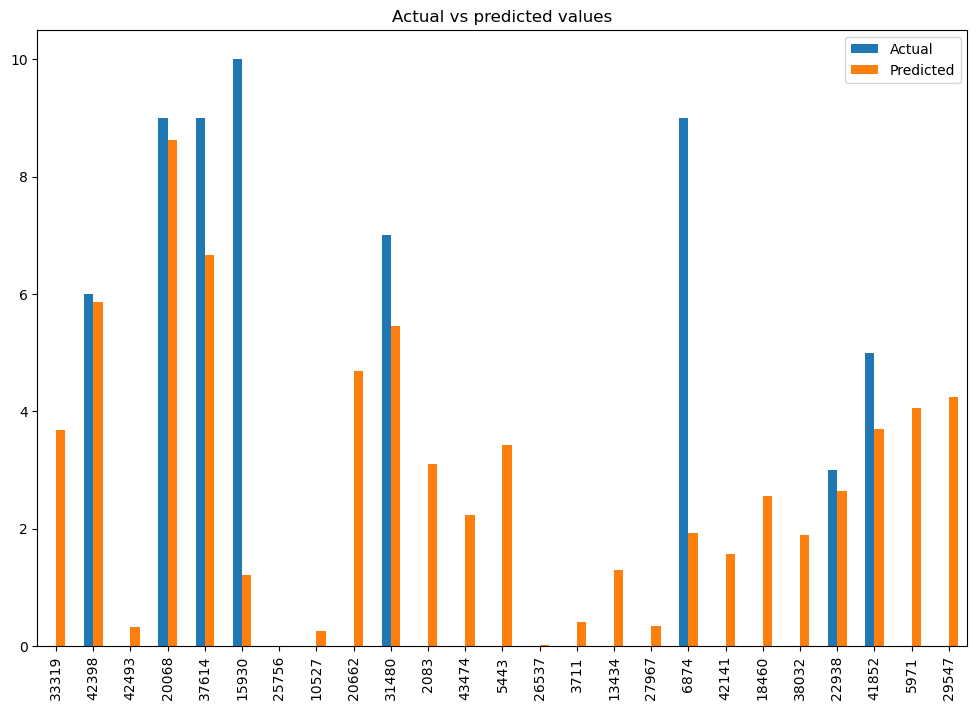

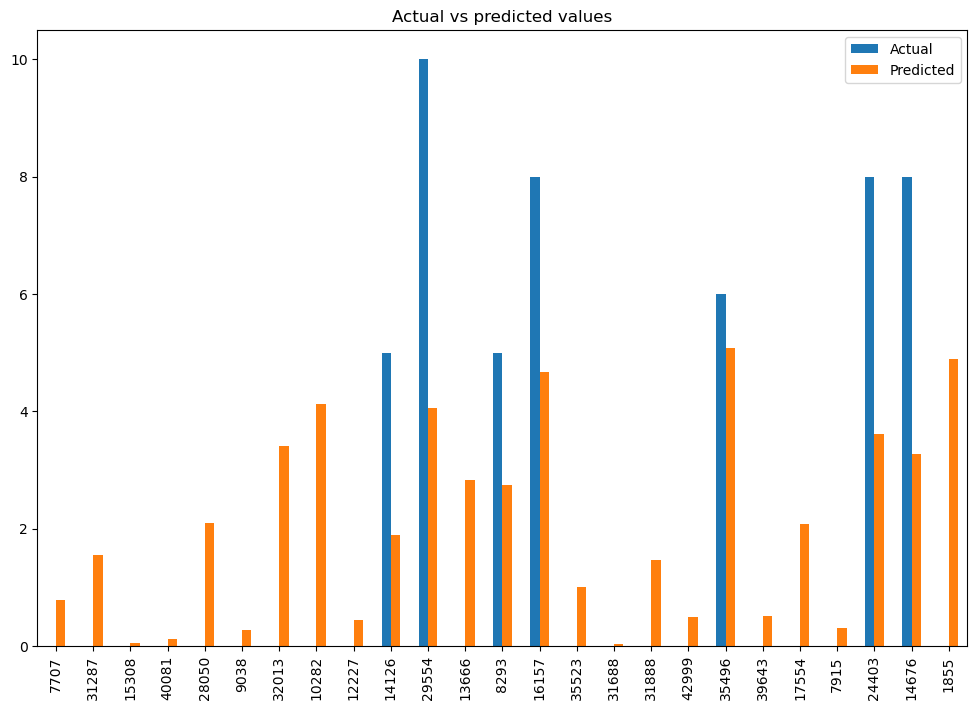

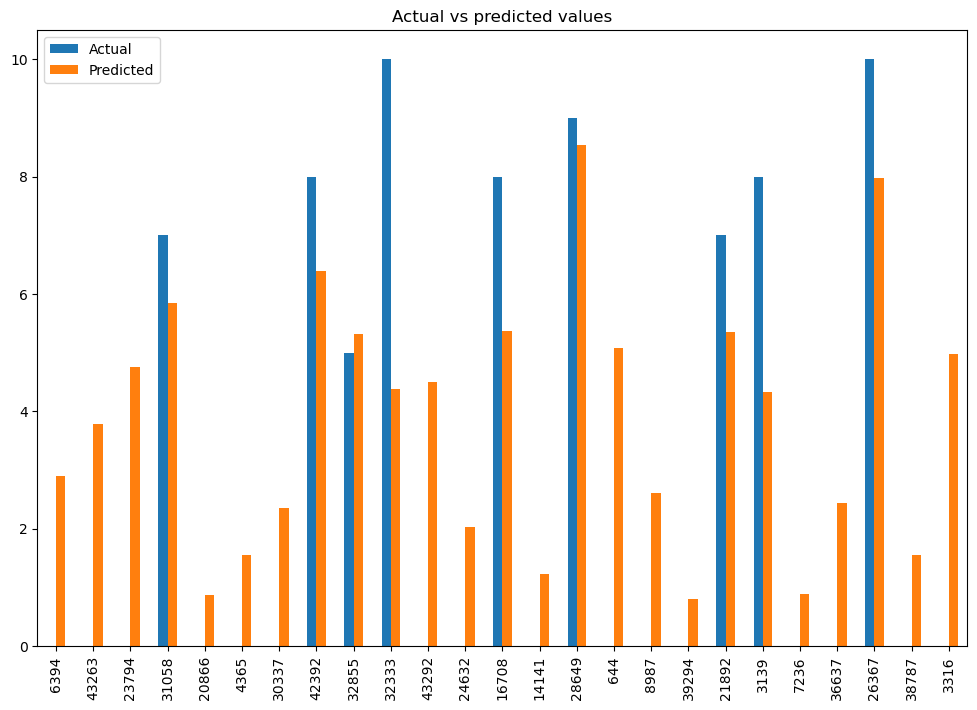

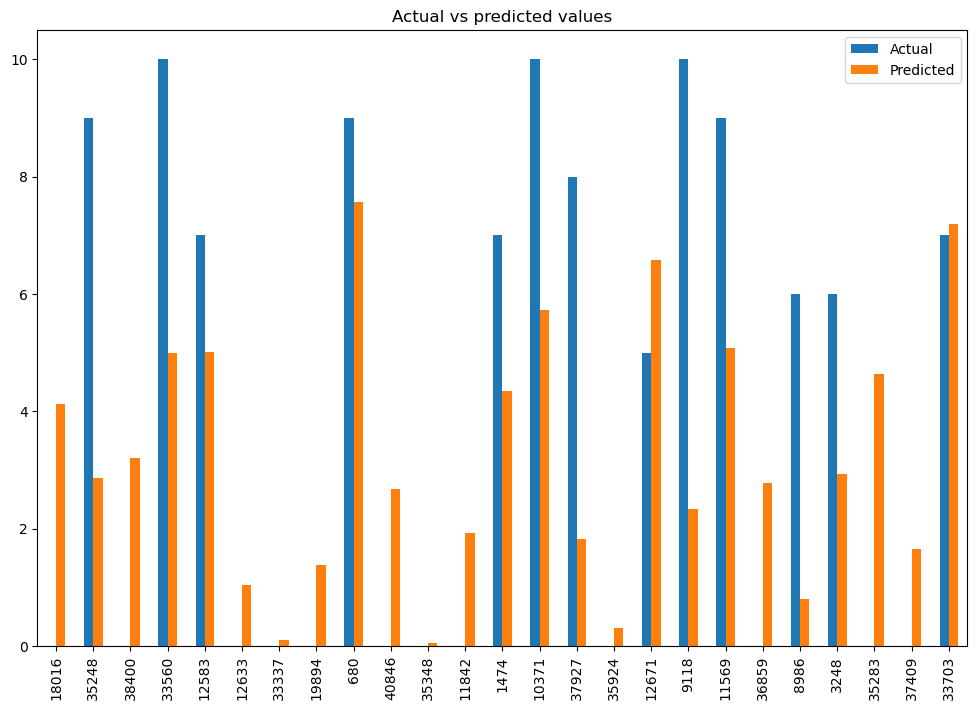

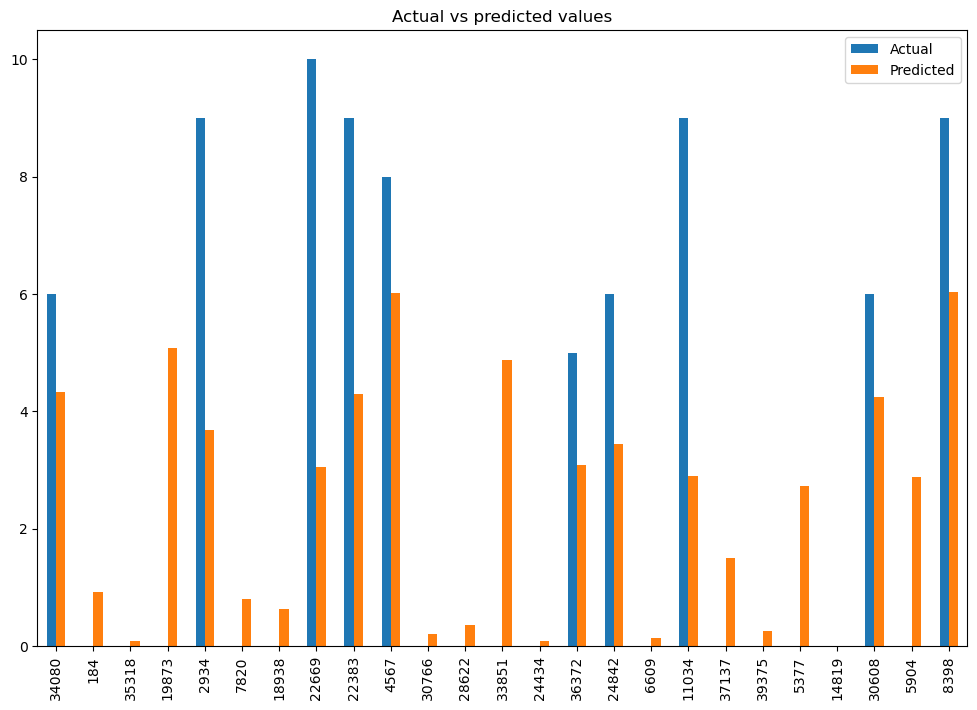

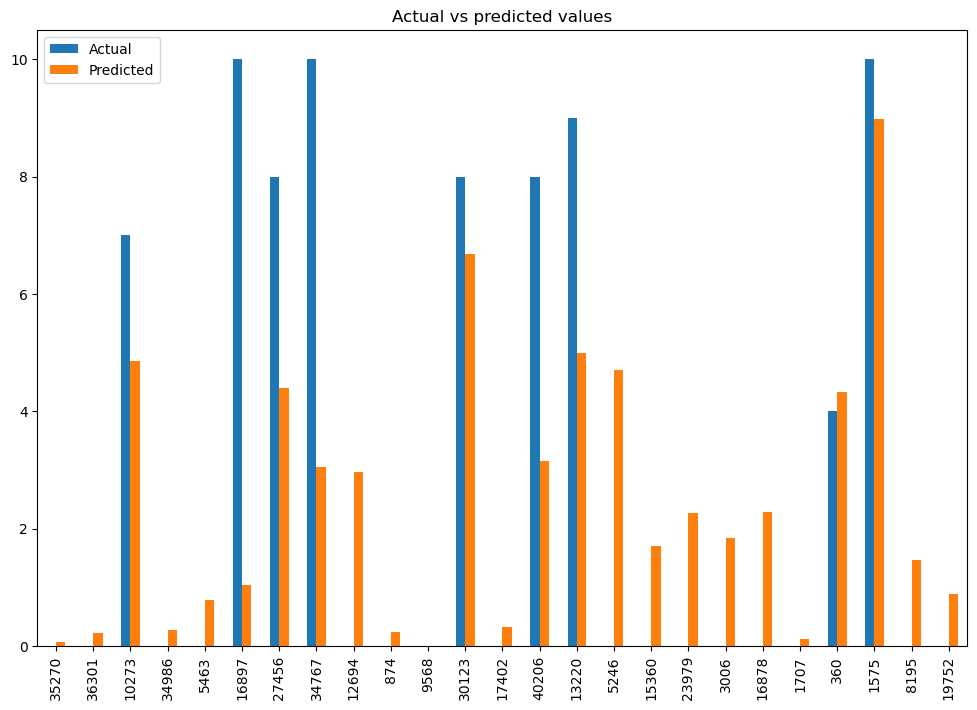

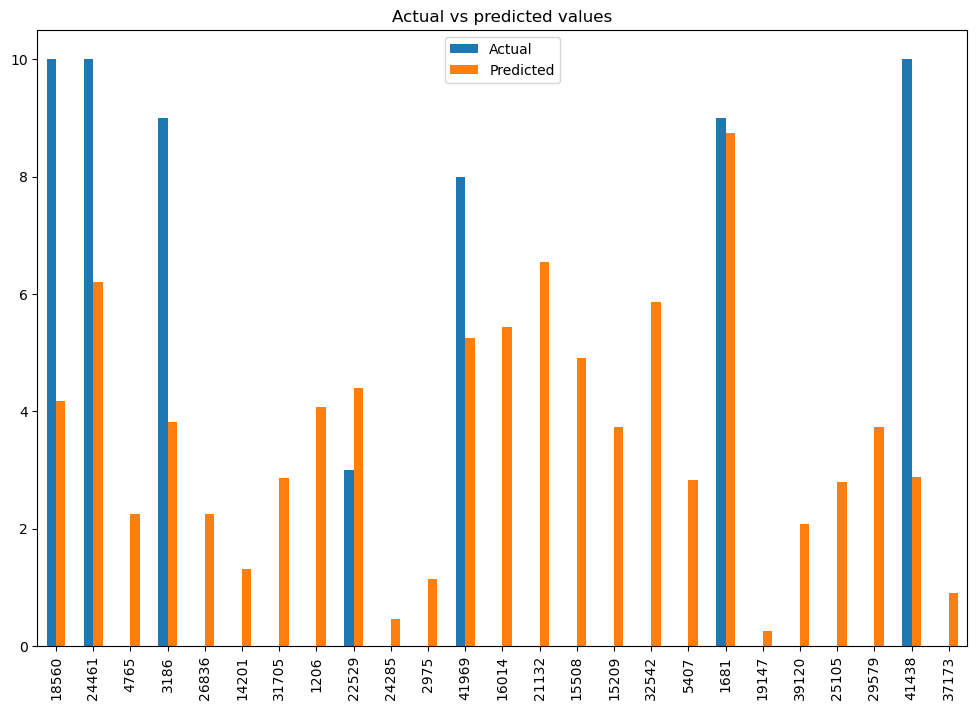

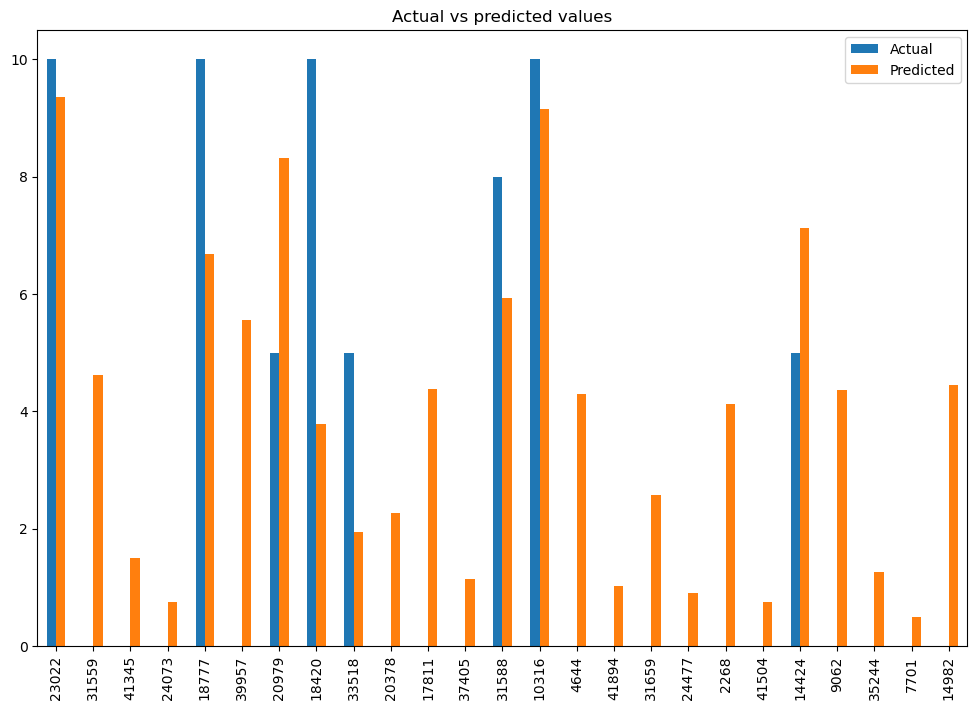

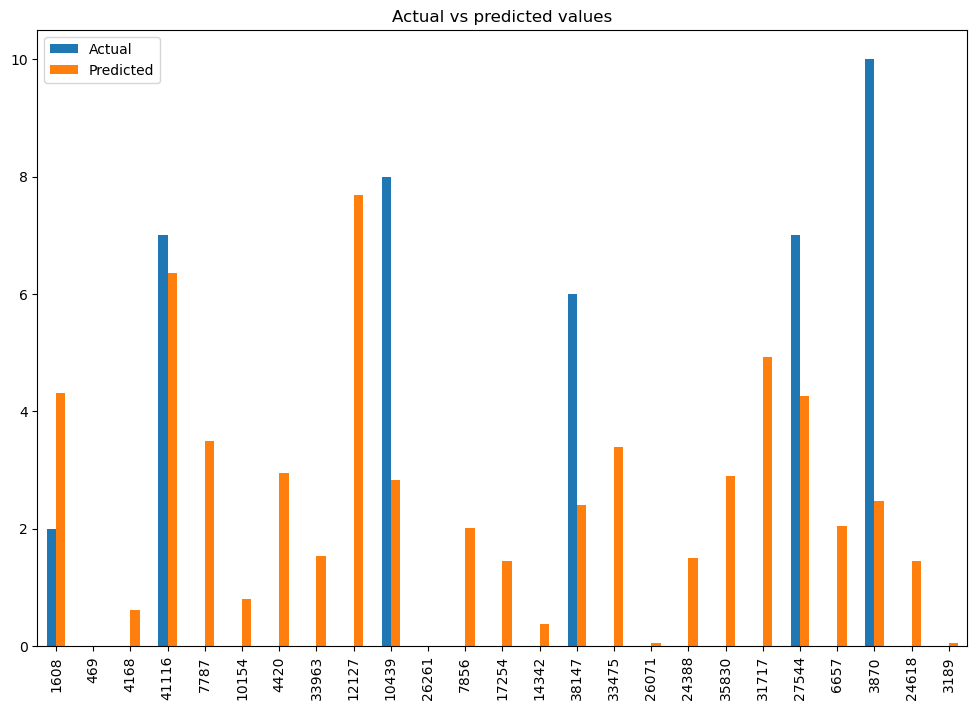

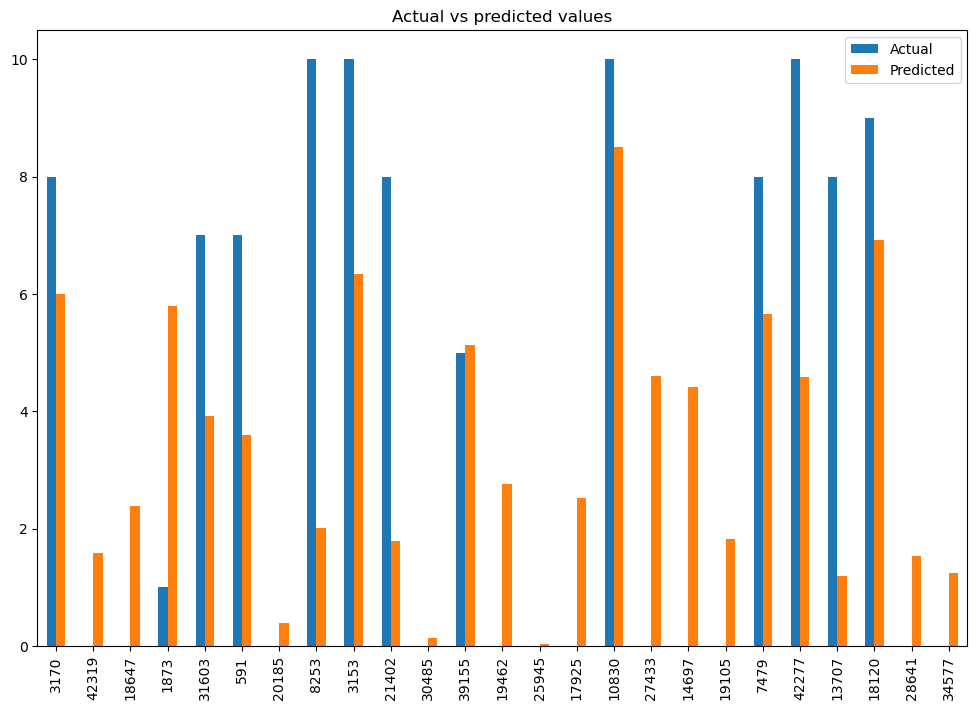

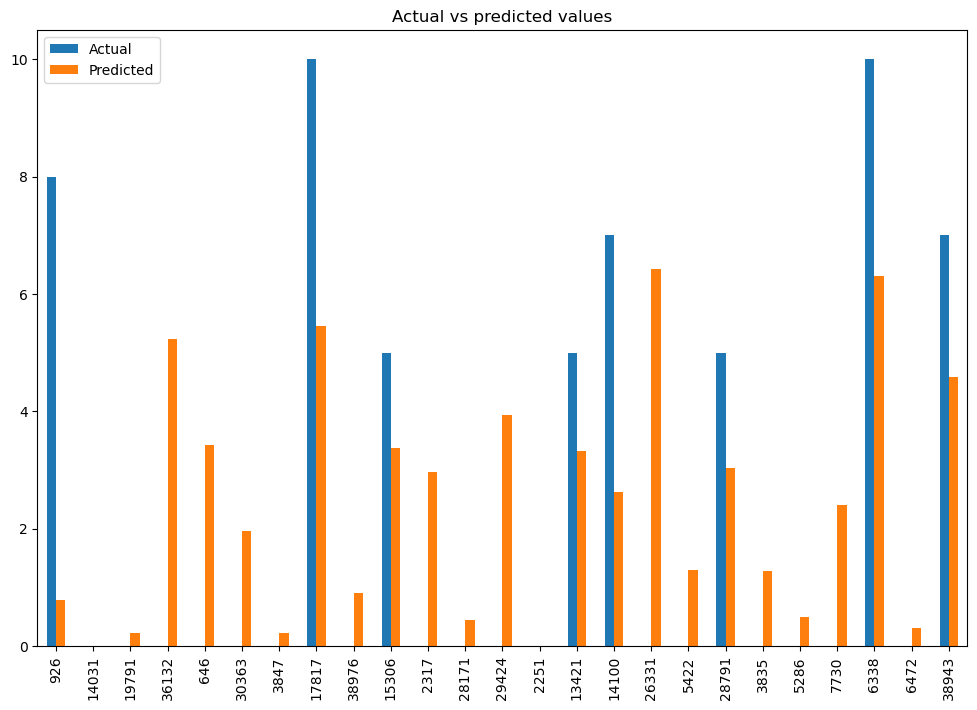

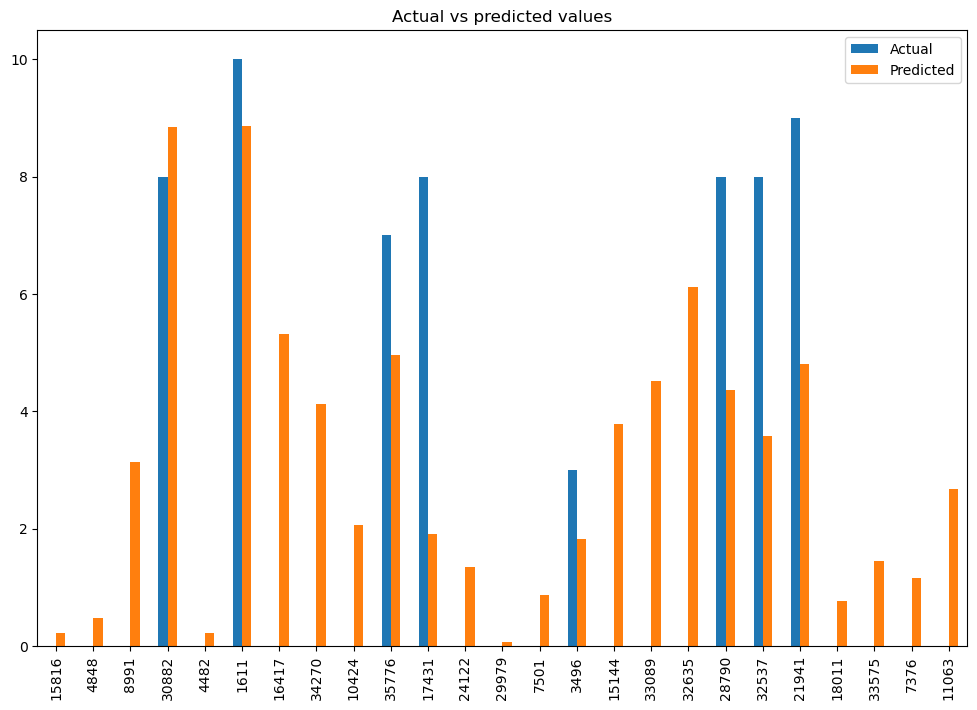

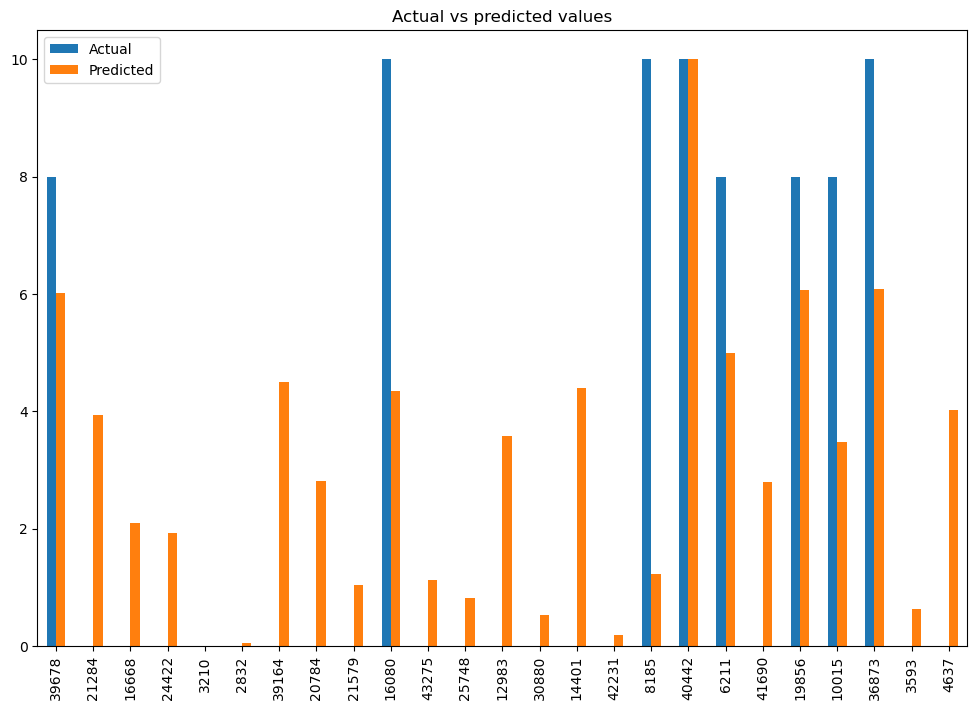

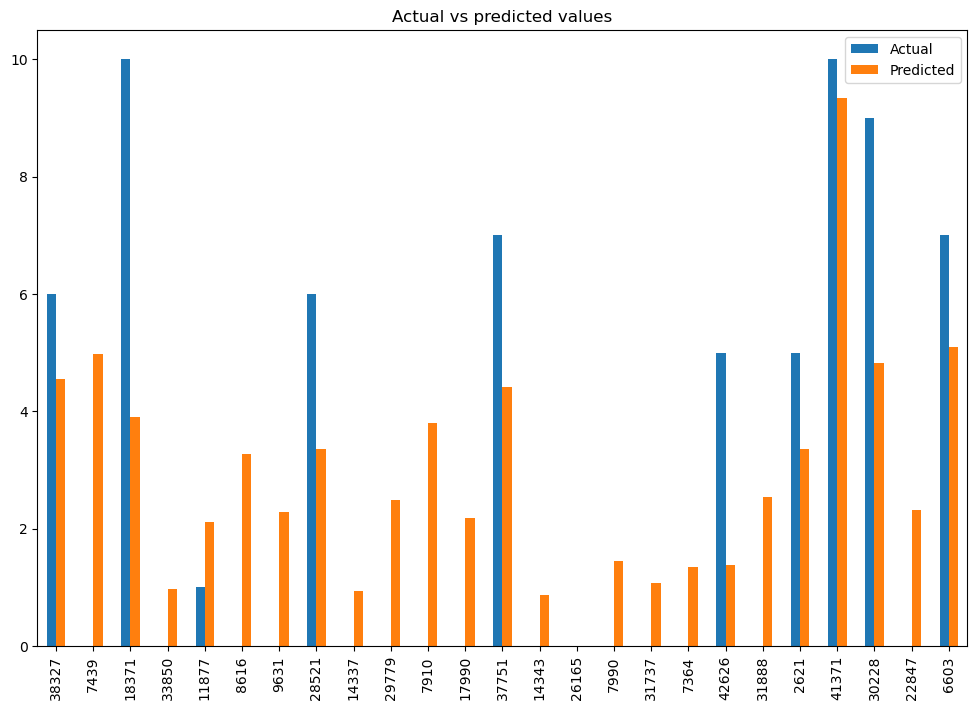

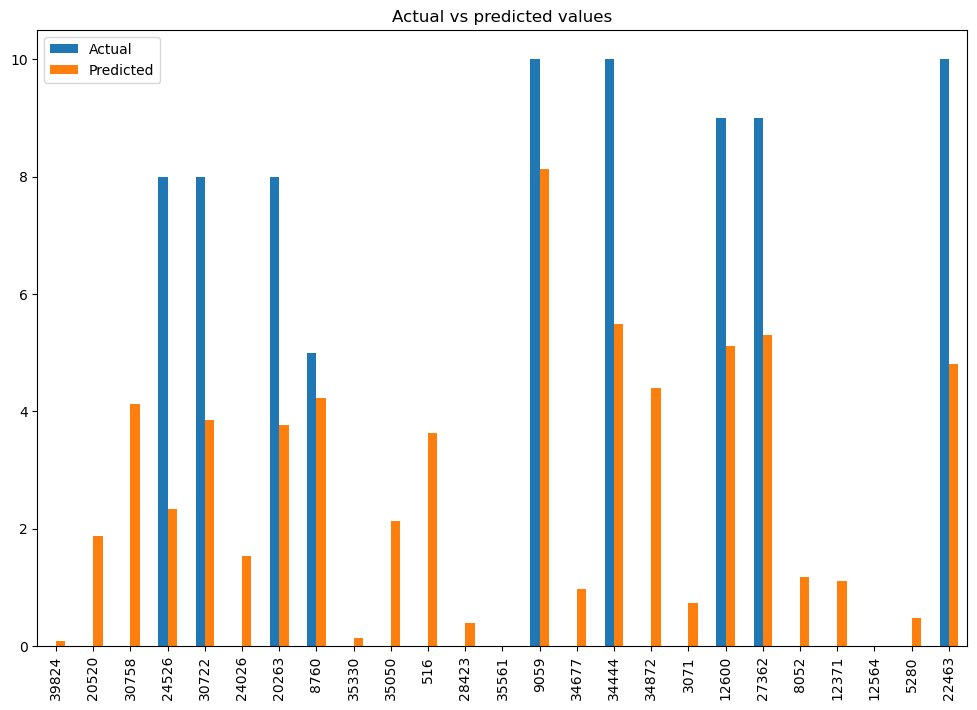

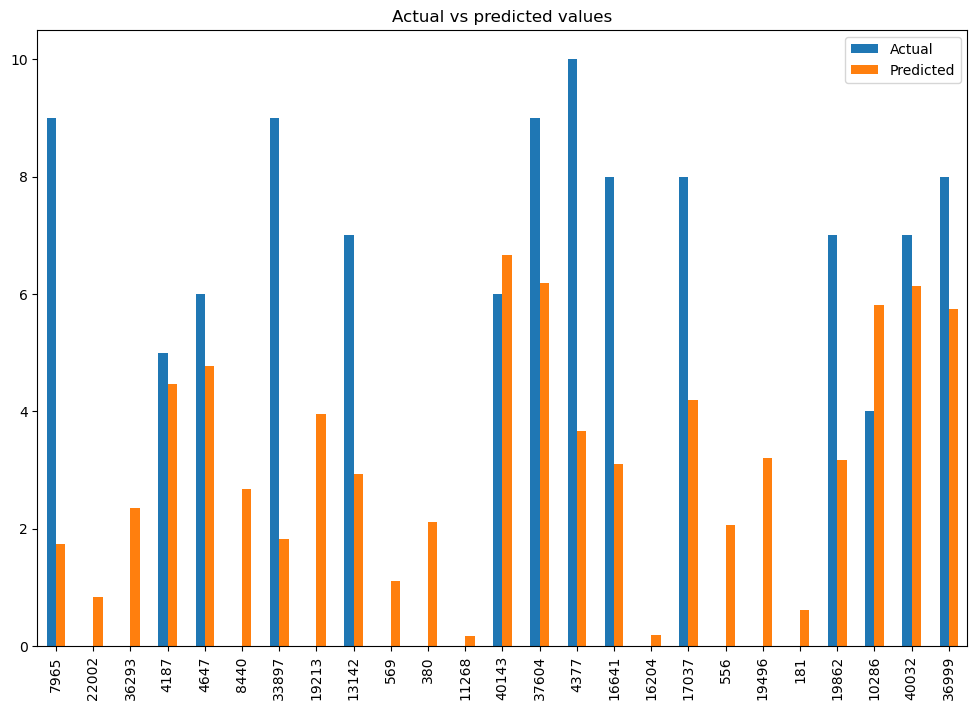

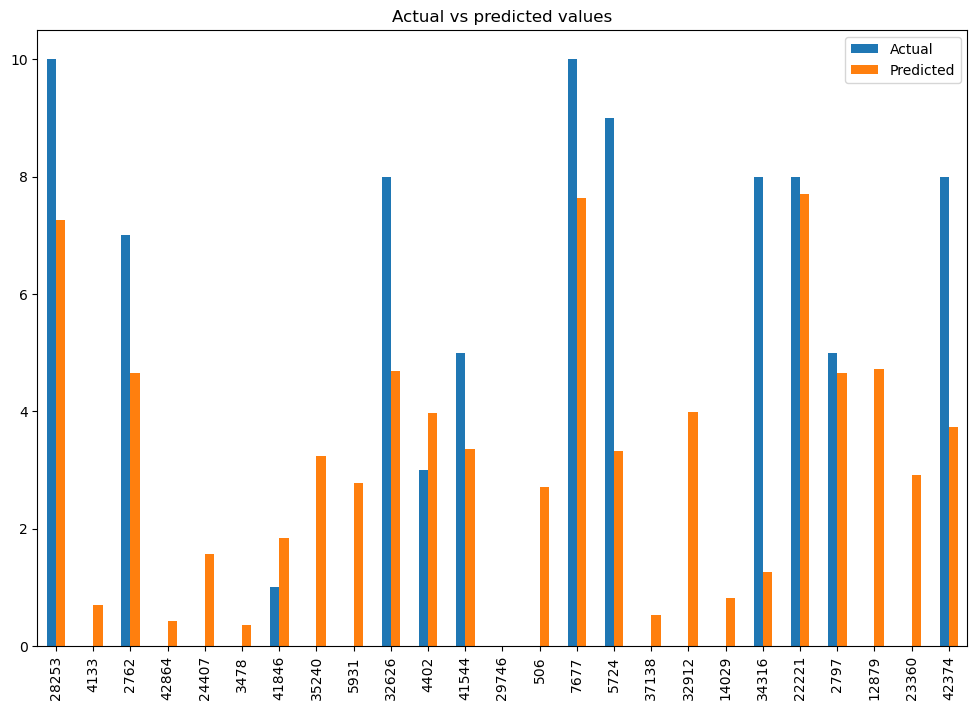

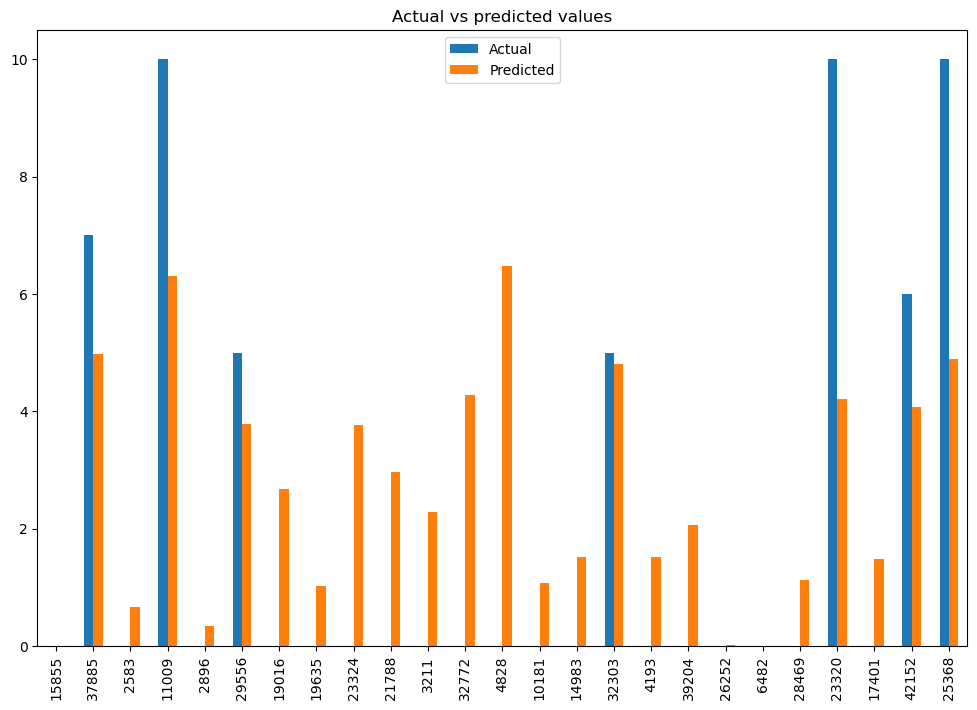

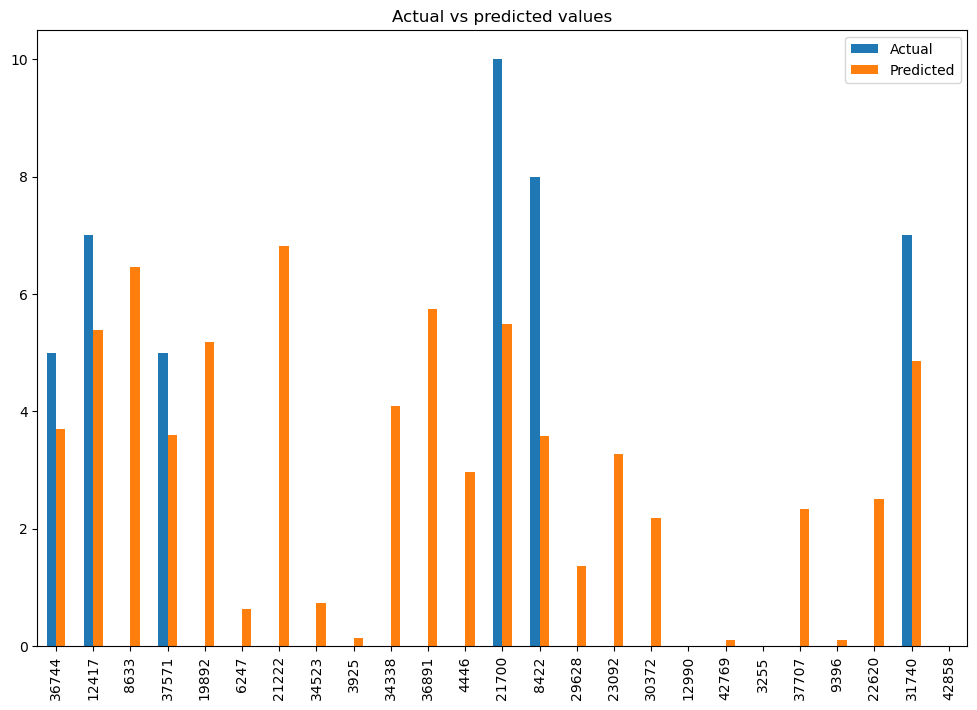

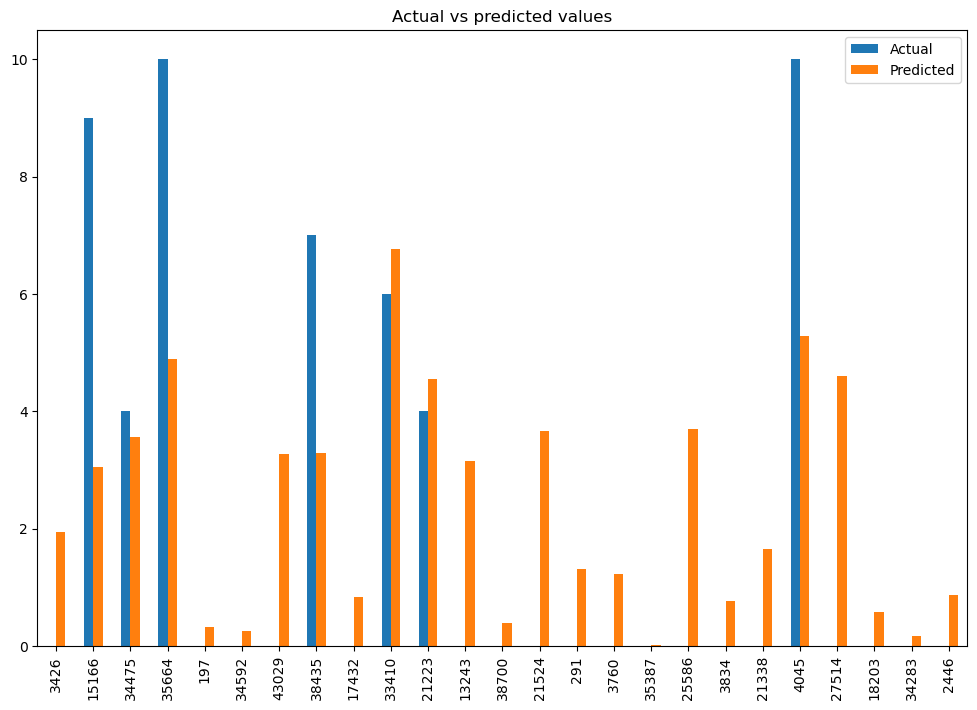

In [16]:
#from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold

k = 20 # a number of folds 
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from catboost import Pool

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb', 'Pub_gb']#, 'Language']#, 'Topic_num']

for i, (train_index, test_index) in enumerate(skfold.split(X_train, y_train)):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')
    # OVER SAMPLING - SMOTE
    #smote_sample = SMOTE(random_state=113, sampling_strategy='minority') 
    #X_train_fold, y_train_fold = smote_sample.fit_resample(X_train_fold, y_train_fold)
    #X_valid_fold, y_valid_fold = smote_sample.fit_resample(X_valid_fold, y_valid_fold)
    
    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)

    
    print( "\nFold ", i)
    
    fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
        

    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
        y_pred = np.clip(model.predict(X_test),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))    
    
    
        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)
    
    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns]),0.0,10.0)
    
y_test_pred /= k  # Average test set predictions


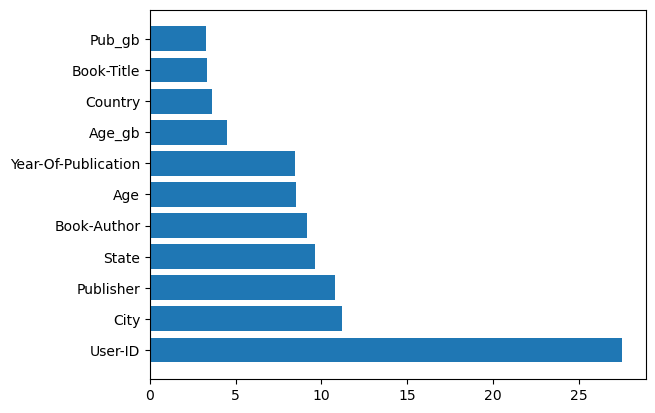

In [21]:
cat_importance_feature = np.argsort(model.feature_importances_)[:-31:-1]
plt.barh(X_train.columns[cat_importance_feature], model.feature_importances_[cat_importance_feature])
plt.show()


In [18]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

,ID,Book-Rating
0,TEST_000000,5.646985
1,TEST_000001,6.506563
2,TEST_000002,6.282612
3,TEST_000003,6.033889
4,TEST_000004,5.759971
...,...,...
159616,TEST_159616,3.967259
159617,TEST_159617,3.873478
159618,TEST_159618,3.702472
159619,TEST_159619,3.813899


<Axes: xlabel='Book-Rating', ylabel='Count'>

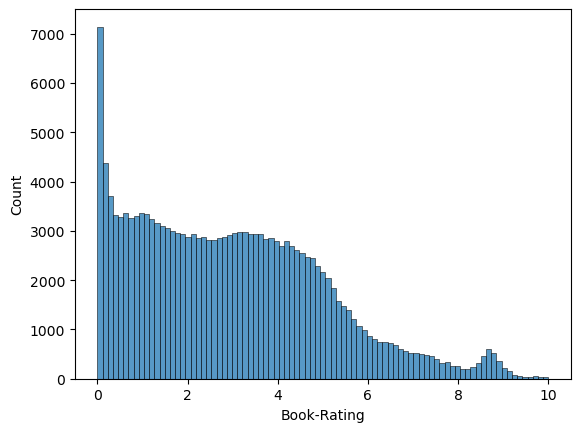

In [19]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [20]:
sub.to_csv('submit_cat+20-folds_bal.csv', index=False,encoding="utf-8-sig")